# Creating population grid

This notebook preprocesses 1-2 population rasters and converts the data into H3 hexagons with information on total population and population densities. The H3 hexagons have the same resolution as the hexagons used when running BikeDNA BIG.

In [1]:
import h3
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import json
import pickle
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray as rxr
from shapely.geometry import Polygon

from src import plotting_functions as plot_func


In [2]:
%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_osmdata.py
%run ../settings/paths.py

h3_res = h3.h3_get_resolution(osm_grid.loc[0,'hex_id'])
print(f"Using H3 resolution {h3_res} for calculating population density")

OSM data loaded successfully!
Using H3 resolution 8 for calculating population density


In [3]:
# LOAD DATA

pop_src_1 = rasterio.open(pop_fp_1)

# check if more than one raster is provided
if pop_fp_2 != None:

    pop_src_2 = rasterio.open(pop_fp_2)

    pop_rasters = [pop_src_1, pop_src_2] # Load and add more rasters here if necessary

else:
    pop_rasters = [pop_src_1]

In [4]:
# MAKE SURE THAT HEXAGONS ARE LARGER THAN PIXELS

avg_area = h3.hex_area(h3_res, unit="m^2")
pixel_area = pop_src_1.res[0] * pop_src_1.res[1]

assert avg_area > pixel_area

In [5]:
# MERGE RASTERS (if more than one is provided)

if pop_fp_2 != None:
    mosaic, out_trans = merge(pop_rasters)

    out_meta = pop_src_1.meta.copy()

    out_meta.update(
        {
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "crs": pop_src_1.crs,
        }
    )
    merged_fp = pop_processed_fp + "merged_pop_raster.tif"
    with rasterio.open(merged_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

    merged = rasterio.open(merged_fp)

else:
    merged = pop_src_1

    print("No merging required - only one population raster has been provided.")

In [6]:
# Load DK boundaries

study_area_poly = gpd.read_file(study_area_fp)
assert study_area_poly.crs == study_crs

study_area_buffer = study_area_poly.buffer(100)

study_area_proj = study_area_buffer.to_crs(merged.crs)
convex = study_area_proj.convex_hull

geo = gpd.GeoDataFrame({"geometry": convex[0]}, index=[0], crs=merged.crs)

coords = [json.loads(geo.to_json())["features"][0]["geometry"]]

# Clip raster to DK extent
clipped, out_transform = mask(merged, shapes=coords, crop=True)

out_meta = merged.meta.copy()

out_meta.update(
    {
        "driver": "GTiff",
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": out_transform,
        "crs": merged.crs,
    }
)
clipped_fp = pop_processed_fp + "clipped_pop_raster.tif"
with rasterio.open(clipped_fp, "w", **out_meta) as dest:
    dest.write(clipped)


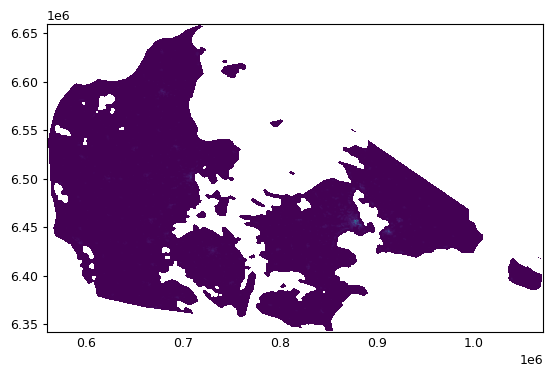

In [7]:
show(rasterio.open(clipped_fp));

In [8]:
# REPROJECT TO CRS USED BY H3
dst_crs = "EPSG:4326"
proj_fp_wgs84 = pop_processed_fp + "reproj_pop_raster_wgs84.tif"

with rasterio.open(clipped_fp) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {"crs": dst_crs, "transform": transform, "width": width, "height": height}
    )

    with rasterio.open(proj_fp_wgs84, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear,
            )

test = rasterio.open(proj_fp_wgs84)
assert test.crs.to_string() == "EPSG:4326"

print("Population data have been merged (if needed), clipped, and reprojected!")


Population data have been merged (if needed), clipped, and reprojected!


In [9]:
# COMBINE WITH H3 DATA

# VECTORIZE
pop_df = (
    rxr.open_rasterio(proj_fp_wgs84)
    .sel(band=1)
    .to_pandas()
    .stack()
    .reset_index()
    .rename(columns={"x": "lng", "y": "lat", 0: "population"})
)

# Ignore no data values
pop_df = pop_df[pop_df.population > -200]

pop_gdf = gpd.GeoDataFrame(pop_df, geometry=gpd.points_from_xy(pop_df.lng, pop_df.lat))

pop_gdf.set_crs("EPSG:4326", inplace=True)

dk_gdf = gpd.GeoDataFrame({"geometry": study_area_proj}, crs=study_area_proj.crs)
dk_gdf.to_crs("EPSG:4326", inplace=True)

pop_gdf = gpd.sjoin(pop_gdf, dk_gdf, predicate="within", how="inner")


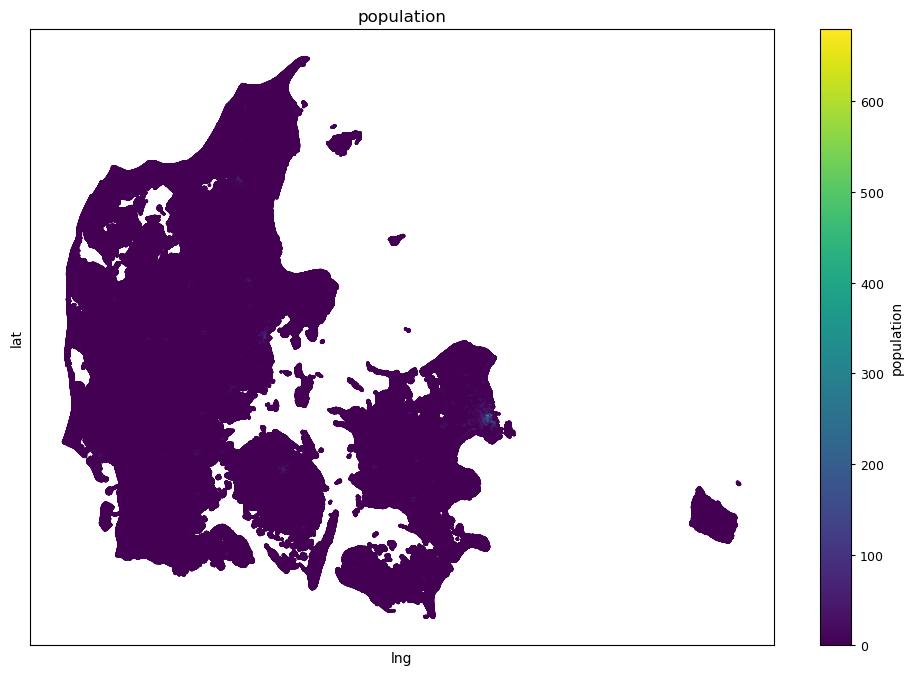

In [10]:
plot_func.plot_scatter(pop_gdf, metric_col="population", marker=".")

In [11]:
# INDEX POPULATION WITH H3

hex_id_col = "hex_id"

pop_gdf[hex_id_col] = pop_gdf.apply(
    lambda row: h3.geo_to_h3(lat=row["lat"], lng=row["lng"], resolution=h3_res), axis=1
)

pop_gdf.head()


,lat,lng,population,geometry,index_right,hex_id
2220,57.753345,10.613979,0.0,POINT (10.61398 57.75334),0,881f24a489fffff
8650,57.752104,10.599091,0.0,POINT (10.59909 57.75210),0,881f24a4ebfffff
8651,57.752104,10.600332,0.0,POINT (10.60033 57.75210),0,881f24a4ebfffff
8652,57.752104,10.601573,0.0,POINT (10.60157 57.75210),0,881f24a48dfffff
8653,57.752104,10.602813,0.0,POINT (10.60281 57.75210),0,881f24a48dfffff


In [12]:
# Convert to H3 polygons
print(f"Creating hexagons at resolution {h3_res}...")

h3_groups = (
    pop_gdf.groupby(hex_id_col)["population"].sum().to_frame("population").reset_index()
)

h3_groups["lat"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[0])
h3_groups["lng"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[1])


h3_groups.head()

Creating hexagons at resolution 8...


,hex_id,population,lat,lng
0,88099269b3fffff,0.006236,56.297197,8.121899
1,88099269b7fffff,0.006372,56.290681,8.125698
2,8809926c13fffff,0.000000,56.441417,8.115076
3,8809926c17fffff,0.000000,56.434920,8.118885
4,8809926c21fffff,0.000000,56.404224,8.111009


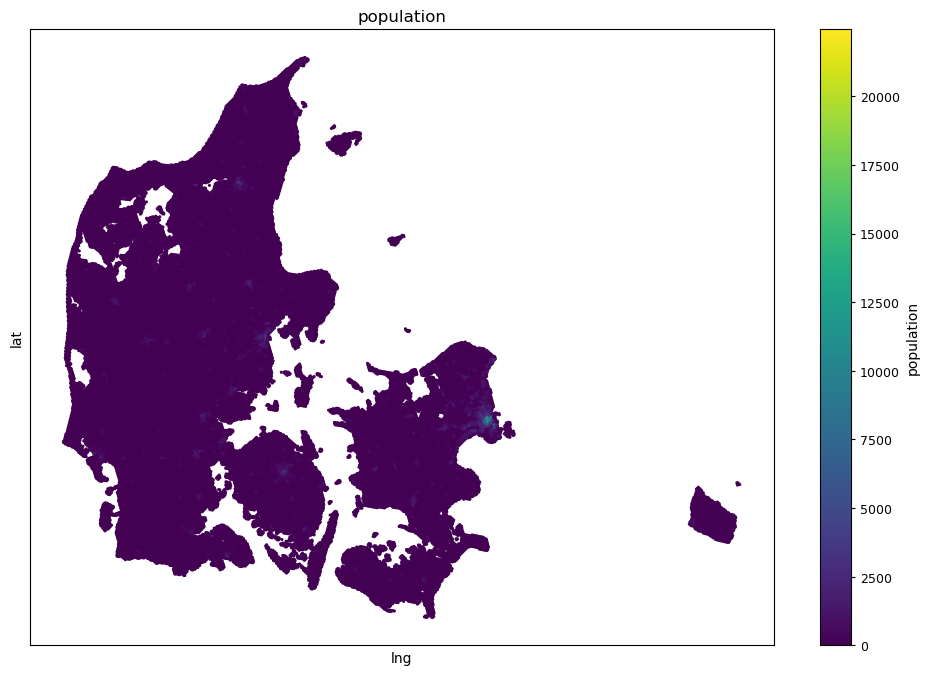

In [14]:
plot_func.plot_scatter(h3_groups, metric_col="population", marker=".")

In [15]:
h3_groups["hex_geometry"] = h3_groups[hex_id_col].apply(
    lambda x: {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=x, geo_json=True)],
    }
)

h3_groups["geometry"] = h3_groups["hex_geometry"].apply(
    lambda x: Polygon(list(x["coordinates"][0]))
)

h3_gdf = gpd.GeoDataFrame(h3_groups, geometry="geometry", crs="EPSG:4326")

h3_gdf.to_crs(study_crs, inplace=True)

h3_gdf.head()


,hex_id,population,lat,lng,hex_geometry,geometry
0,88099269b3fffff,0.006236,56.297197,8.121899,"{'type': 'Polygon', 'coordinates': [((8.116155...","POLYGON ((445304.683 6239784.054, 445178.643 6..."
1,88099269b7fffff,0.006372,56.290681,8.125698,"{'type': 'Polygon', 'coordinates': [((8.119955...","POLYGON ((445530.557 6239055.868, 445404.516 6..."
2,8809926c13fffff,0.000000,56.441417,8.115076,"{'type': 'Polygon', 'coordinates': [((8.109318...","POLYGON ((445089.360 6255840.006, 444963.469 6..."
3,8809926c17fffff,0.000000,56.434920,8.118885,"{'type': 'Polygon', 'coordinates': [((8.113128...","POLYGON ((445314.908 6255113.857, 445189.015 6..."
4,8809926c21fffff,0.000000,56.404224,8.111009,"{'type': 'Polygon', 'coordinates': [((8.105255...","POLYGON ((444785.010 6251703.853, 444659.070 6..."


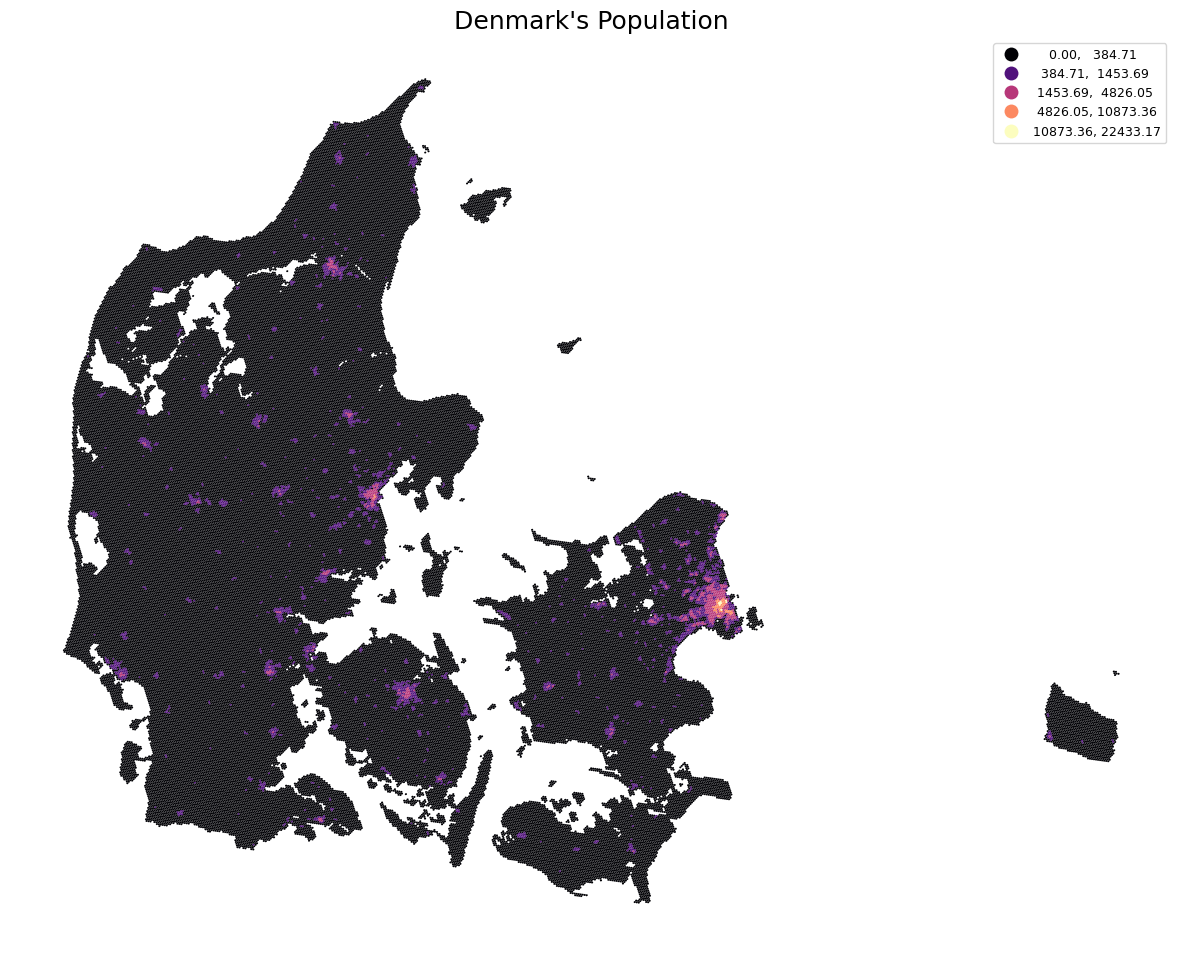

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_axis_off()

h3_gdf.plot(
    ax=ax, column="population", cmap="magma", legend=True, scheme='NaturalBreaks',#legend_kwds={"shrink": 0.6}
)

plt.title(area_name + "'s Population", fontsize=18);


In [17]:
# COMPUTE POP DENS
h3_gdf["area_sqkm"] = h3_gdf.area / 1000000
h3_gdf["pop_dens"] = h3_gdf.population / h3_gdf.area_sqkm

h3_gdf.head()

,hex_id,population,lat,lng,hex_geometry,geometry,area_sqkm,pop_dens
0,88099269b3fffff,0.006236,56.297197,8.121899,"{'type': 'Polygon', 'coordinates': [((8.116155...","POLYGON ((445304.683 6239784.054, 445178.643 6...",0.579062,0.010769
1,88099269b7fffff,0.006372,56.290681,8.125698,"{'type': 'Polygon', 'coordinates': [((8.119955...","POLYGON ((445530.557 6239055.868, 445404.516 6...",0.579180,0.011001
2,8809926c13fffff,0.000000,56.441417,8.115076,"{'type': 'Polygon', 'coordinates': [((8.109318...","POLYGON ((445089.360 6255840.006, 444963.469 6...",0.576791,0.000000
3,8809926c17fffff,0.000000,56.434920,8.118885,"{'type': 'Polygon', 'coordinates': [((8.113128...","POLYGON ((445314.908 6255113.857, 445189.015 6...",0.576908,0.000000
4,8809926c21fffff,0.000000,56.404224,8.111009,"{'type': 'Polygon', 'coordinates': [((8.105255...","POLYGON ((444785.010 6251703.853, 444659.070 6...",0.577352,0.000000


In [18]:
# Export data
h3_gdf[["hex_id", "population", "pop_dens", "geometry"]].to_parquet(
    pop_processed_fp + f"h3_population_polygons_{study_area}.parquet"
)


In [ ]:
# h3_gdf[["hex_id", "population", "pop_dens", "geometry"]].to_file(
#     pop_processed_fp + f"h3_population_polygons_{study_area}.gpkg"
# )